# SVC

In [23]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
df = pd.read_csv('datas/df_ml.csv', delimiter=";")

In [3]:
df = df[df['sexe'] >= 0]

In [4]:
df.shape

(303392, 17)

In [5]:
df.head()

,luminosité,intersection,collision,agglomération,route,profil,courbe,surface,amenagement,categorie,choc1,manoeuvre,grave,sexe,âge,trajet,secu
0,éclairé,intersection,sans vehicule,agglomération,communale,plat,rectiligne,humide,présence,2 roues moteur,arrière,droit,1,1,25-60 ans,non routinier,casque et autres équipements
1,éclairé,intersection,sans vehicule,agglomération,communale,plat,rectiligne,humide,présence,2 roues moteur,arrière,droit,1,1,25-60 ans,non routinier,casque et autres équipements
2,éclairé,hors intersection,autre,agglomération,departementale,plat,rectiligne,humide,présence,4 roues,avant,droit,0,2,25-60 ans,non routinier,ceinture
3,éclairé,hors intersection,autre,agglomération,departementale,plat,rectiligne,humide,présence,4 roues,avant,droit,2,1,25-60 ans,non routinier,rien
4,éclairé,intersection,avec vehicule,agglomération,departementale,plat,rectiligne,humide,présence,2 roues moteur,avant,tourne,2,1,25-60 ans,non routinier,casque et autres équipements


In [6]:
def categorize_grav(valeur):
    if valeur in [2, 3]:
        return "grave"
    elif valeur in [0, 1]:
        return "leger"
    
df["blessure"] = df['grave'].apply(categorize_grav)

In [7]:
df= df.drop(columns=['grave'])

In [8]:
df = df.rename(columns={'blessure':'grave'})

In [9]:
df.head()

,luminosité,intersection,collision,agglomération,route,profil,courbe,surface,amenagement,categorie,choc1,manoeuvre,sexe,âge,trajet,secu,grave
0,éclairé,intersection,sans vehicule,agglomération,communale,plat,rectiligne,humide,présence,2 roues moteur,arrière,droit,1,25-60 ans,non routinier,casque et autres équipements,leger
1,éclairé,intersection,sans vehicule,agglomération,communale,plat,rectiligne,humide,présence,2 roues moteur,arrière,droit,1,25-60 ans,non routinier,casque et autres équipements,leger
2,éclairé,hors intersection,autre,agglomération,departementale,plat,rectiligne,humide,présence,4 roues,avant,droit,2,25-60 ans,non routinier,ceinture,leger
3,éclairé,hors intersection,autre,agglomération,departementale,plat,rectiligne,humide,présence,4 roues,avant,droit,1,25-60 ans,non routinier,rien,grave
4,éclairé,intersection,avec vehicule,agglomération,departementale,plat,rectiligne,humide,présence,2 roues moteur,avant,tourne,1,25-60 ans,non routinier,casque et autres équipements,grave


In [10]:
X = df.drop(['grave'], axis=1)
y = df['grave']

In [11]:
X.columns

Index(['luminosité', 'intersection', 'collision', 'agglomération', 'route',
       'profil', 'courbe', 'surface', 'amenagement', 'categorie', 'choc1',
       'manoeuvre', 'sexe', 'âge', 'trajet', 'secu'],
      dtype='object')

In [12]:
print('Distribution initiale des classes:', Counter(y))

Distribution initiale des classes: Counter({'leger': 257154, 'grave': 46238})


In [13]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print('Distribution après undersampling:', Counter(y_resampled))

Distribution après undersampling: Counter({'grave': 46238, 'leger': 46238})


In [14]:
col_a_encoder = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
ct =ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop = 'first'), col_a_encoder)], remainder='passthrough')
X_resampled = np.array(ct.fit_transform(X_resampled))
print(X_resampled)

[[1. 0. 0. ... 0. 1. 1.]
 [1. 0. 1. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 1.]
 ...
 [1. 0. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [15]:
encoded_columns = ct.named_transformers_['encoder'].get_feature_names_out([X.columns[i] for i in col_a_encoder])
remaining_columns = [X.columns[i] for i in range(len(X.columns)) if i not in col_a_encoder]
new_columns = np.concatenate([encoded_columns, remaining_columns])

In [16]:
print(new_columns)

['luminosité_éclairé' 'luminosité_nan' 'intersection_intersection'
 'intersection_nan' 'collision_avec vehicule' 'collision_sans vehicule'
 'agglomération_hors agglomération' 'route_communale'
 'route_departementale' 'profil_plat' 'courbe_rectiligne'
 'surface_normale' 'amenagement_présence' 'categorie_2 roues moteur'
 'categorie_4 roues' 'categorie_autre' 'choc1_aucun' 'choc1_avant'
 'choc1_côté' 'manoeuvre_droit' 'manoeuvre_immobile' 'manoeuvre_tourne'
 'âge_25-60 ans' 'âge_60 ans et plus' 'âge_Moins de 18 ans'
 'trajet_routinier' 'secu_ceinture' 'secu_rien' 'sexe']


In [17]:
X_resampled.shape

(92476, 29)

In [18]:
X_train, X_test, y_train, y_test =  train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled)

In [19]:
print(X_train.shape)
print(X_test.shape)

(73980, 29)
(18496, 29)


In [ ]:
#Je teste les différents kernels pour trouver le meilleur

# kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# best_score = 0
# best_kernel = None
# for kernel in kernels:
#     model = svm.SVC(kernel='poly', degree=3)
#     scores = cross_val_score(model, X_train, y_train, cv=5)
#     mean_score = scores.mean()
#     print(f"Kernel : {kernel}, Score: {mean_score}")

#     if mean_score > best_score:
#         best_score = mean_score
#         best_kernel=kernel

# print(f"Best_kernel: {best_kernel}, Best_score: {best_score}")

In [ ]:
# model = svm.SVC(kernel="poly", degree=3)
# model.fit(X_train, y_train)

In [20]:
model = svm.SVC(kernel="linear")
model.fit(X_train, y_train)

SVC(kernel='linear')

In [21]:
coeff = model.coef_

df_imp = pd.DataFrame({
    'Feature': new_columns,
    'Coefficient': coeff[0]
})
print(df_imp.head())

                     Feature  Coefficient
0         luminosité_éclairé     0.332480
1             luminosité_nan     0.000000
2  intersection_intersection     0.127588
3           intersection_nan     0.991006
4    collision_avec vehicule     0.553138


In [22]:
df_imp = df_imp.sort_values(by='Coefficient', ascending=False)
print(df_imp[['Feature', 'Coefficient']])

                             Feature  Coefficient
26                     secu_ceinture     2.304118
27                         secu_rien     1.021634
3                   intersection_nan     0.991006
4            collision_avec vehicule     0.553138
24               âge_Moins de 18 ans     0.440287
0                 luminosité_éclairé     0.332480
20                manoeuvre_immobile     0.289589
10                 courbe_rectiligne     0.275515
21                  manoeuvre_tourne     0.238707
22                     âge_25-60 ans     0.182301
9                        profil_plat     0.128411
2          intersection_intersection     0.127588
19                   manoeuvre_droit     0.068909
25                  trajet_routinier     0.036693
1                     luminosité_nan     0.000000
11                   surface_normale    -0.047262
28                              sexe    -0.086311
13          categorie_2 roues moteur    -0.123395
7                    route_communale    -0.142882


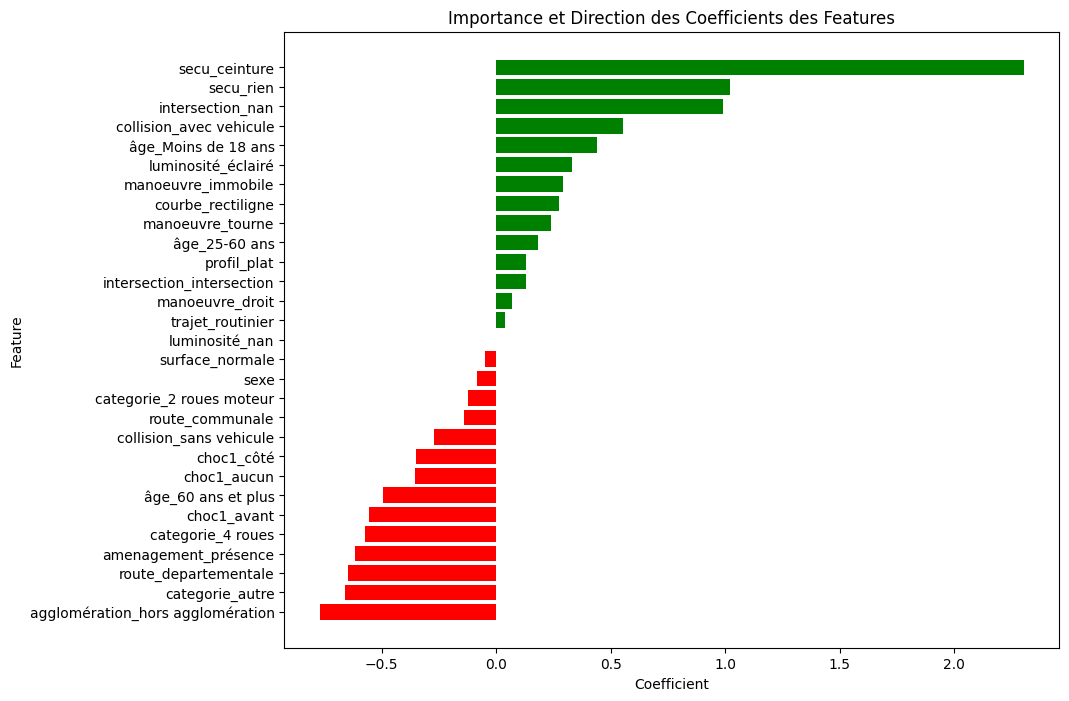

In [24]:
plt.figure(figsize=(10,8))
plt.barh(df_imp['Feature'], df_imp['Coefficient'], color=['green' if coef > 0 else 'red' for coef in df_imp['Coefficient']])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Importance et Direction des Coefficients des Features')
plt.gca().invert_yaxis()
plt.show()

In [19]:
y_pred = model.predict(X_test)
score = accuracy_score(y_pred, y_test)
print(score)

0.7219398788927336


In [20]:
#matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print (cm)

[[6845 2403]
 [2740 6508]]


<Axes: >

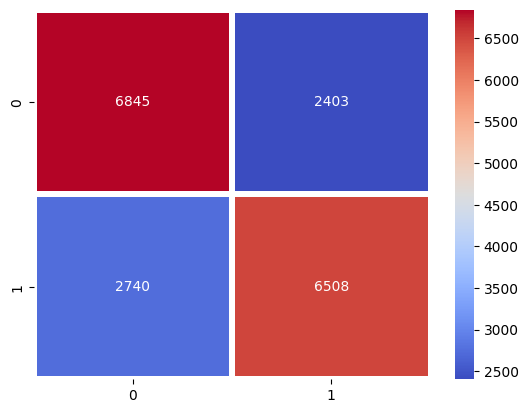

In [21]:
cm_heatmap = pd.DataFrame(cm)
sns.heatmap(cm_heatmap, annot=True, cmap="coolwarm", fmt="d", linewidths=4)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       grave       0.71      0.74      0.73      9248
       leger       0.73      0.70      0.72      9248

    accuracy                           0.72     18496
   macro avg       0.72      0.72      0.72     18496
weighted avg       0.72      0.72      0.72     18496

